In [19]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import os
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import umap
from sklearn import metrics
import utils
from math import pi


In [20]:
train = pd.read_csv(os.path.join(os.path.curdir, 'all_videos.csv'), index_col=[0, 1, -3])
# index col = (frame, face_id, filename)
target_emotion = 'contempt'
target_culture = 'Persian'
train = train[(train['emotion'] == target_emotion) & (train['culture'] == target_culture)]
# test_csv
test = pd.read_csv(os.path.join(os.path.curdir, 'processed_test.csv'), index_col=[0, 1, -3])

train_feats = train.filter(regex='AU.+')

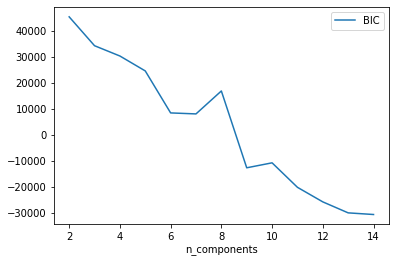

In [21]:
n_components = np.arange(2, 15)
models = [GaussianMixture(n, covariance_type='full', random_state=0, max_iter=400).fit(train_feats.values)
          for n in n_components]
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(n_components, [m.bic(train_feats) for m in models], label='BIC', )
# plt.plot(n_components, [m.aic(train_feats) for m in models], label='AIC')

plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

The most reasonable number of clusters seems to be $components=6$ according to BIC curve

In [22]:
best_model: GaussianMixture = models[4]

# Finding nearest neighbors in processed data:
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(best_model.means_, train_feats)
print('closest: ', closest)
frame_video_pairs =  [train_feats.iloc[i].name for i in closest]
print(frame_video_pairs)
# 9 cluster [(36, 18), (92, 11), (11, 22), (67, 20), (31, 22), (32, 9), (1, 33), (30, 5), (33, 9)] for 9 clusters
# Coefficients:
print(best_model.weights_)
print(best_model.weights_.shape)
# extract image of frame using this command:
# ffmpeg -i <input> -vf "select=eq(n\,34)" -vframes 1 out.png
# ffmpeg -i 9.mp4 -vf "select=eq(n\,32)" -vframes 1 cluster_2.png


closest:  [3066 2030 1513 1922 1718 1294]
[(48, 0, '63'), (63, 0, '42'), (145, 1, '76'), (90, 1, '60'), (256, 2, '76'), (36, 0, '76')]
[0.07498707 0.23592686 0.13724852 0.40127276 0.03026549 0.12029929]
(6,)


## Radar charts of clusters:
### TODO: Refactore and remove ``df``

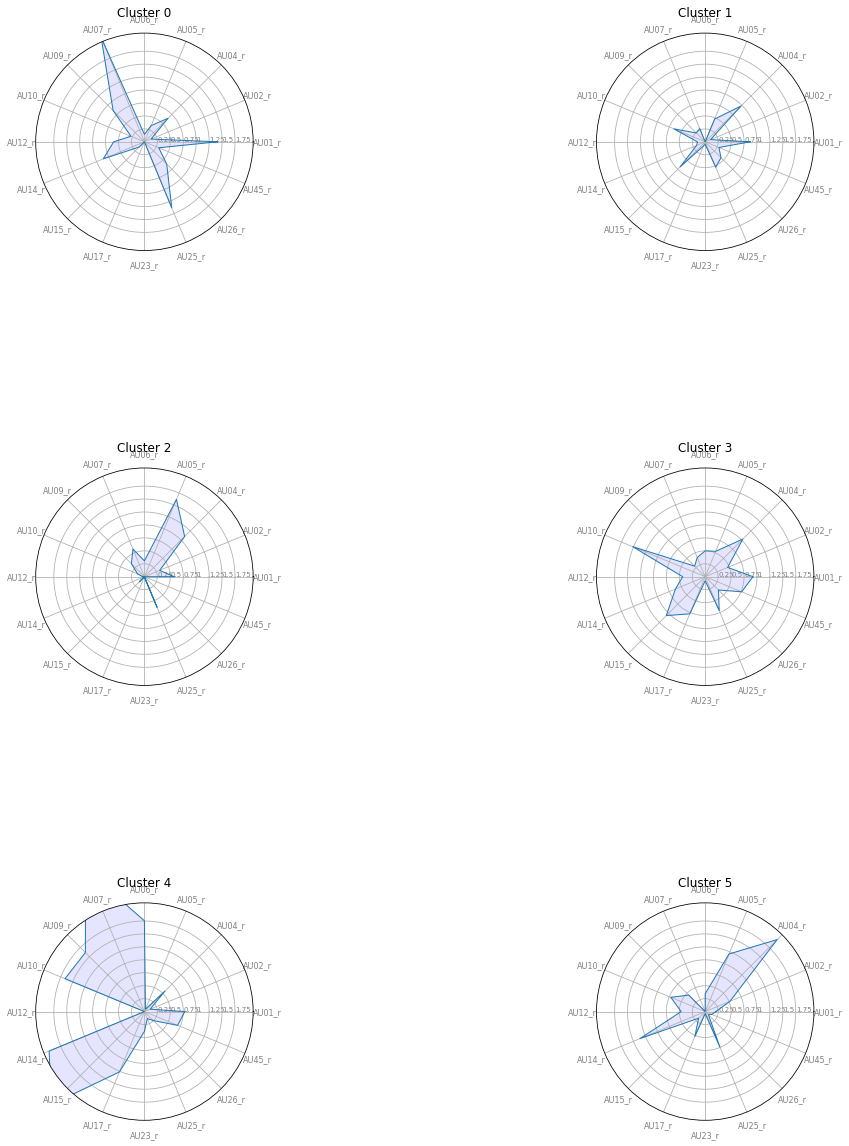

In [34]:
df = pd.DataFrame(columns=train_feats.columns, data=best_model.means_)
 
# number of variable
# list(df) returns col headers
categories=list(df)
N = len(categories)

fig, axs = plt.subplots(3, 3, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.01)

axs = axs.ravel()
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
for i in range(len(best_model.means_)):
    values=df.iloc[i]
    # print(values)
    values = values.values.flatten().tolist()
    # print(values)
    values += values[:1]
    # print('%%%%%%%%%%%%%%           ', values, len(values))

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the spider plot
    axs[i] = plt.subplot(321 + i, polar=True)
    
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    
    # Draw ylabels
    axs[i].set_rlabel_position(0)
    plt.yticks([0.25,0.5,0.75, 1.0, 1.25, 1.5, 1.75], ["0.25","0.5","0.75", "1", "1.25", "1.5", '1.75'], color="grey", size=7)
    plt.ylim(0,2.1)
    
    # Plot data
    axs[i].plot(angles, values, linewidth=1, linestyle='solid')
    
    axs[i].set_title('Cluster ' + str(i))
    # Fill area
    axs[i].fill(angles, values, 'b', alpha=0.1)

## Dimensionality Reduction with UMAP

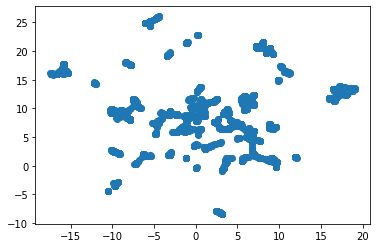

In [24]:
my_umap = umap.UMAP(random_state=42, )
reduced_train = my_umap.fit_transform(train_feats,)
plt.scatter(reduced_train[:, 0], reduced_train[:, 1])
plt.show()

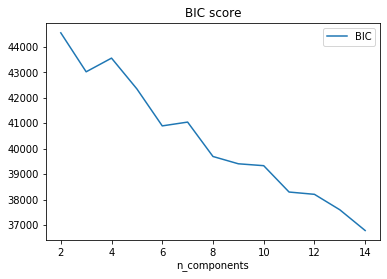

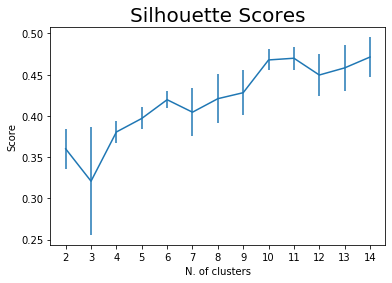

In [25]:

reduced_models = [GaussianMixture(n, covariance_type='full', random_state=0, max_iter=100).fit(reduced_train)
          for n in n_components]
iterations = 20
sils=[]
sils_err=[]
for n in n_components:
    tmp_sil=[]
    for _ in range(iterations):
        gmm = GaussianMixture(n, n_init=2).fit(reduced_train)
        labels = gmm.predict(reduced_train)
        sil=metrics.silhouette_score(reduced_train, labels, metric='euclidean')
        tmp_sil.append(sil)
    val = np.mean(utils.select_best(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(n_components, [m.bic(reduced_train) for m in reduced_models], label='BIC', )
# plt.plot(n_components, [m.aic(reduced_train) for m in reduced_models], label='AIC')

plt.legend(loc='best')
plt.xlabel('n_components')
plt.title('BIC score')
plt.show()

plt.errorbar(n_components, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_components)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.show()

In [26]:
best_model_reduced: GaussianMixture = reduced_models[4]

# Finding nearest neighbors in processed data:
closest, _ = pairwise_distances_argmin_min(reduced_models[4].means_, reduced_train)
print('closest: ', closest)
frame_video_pairs =  [train_feats.iloc[i].name for i in closest]
print(frame_video_pairs)
# 9 cluster [(36, 18), (92, 11), (11, 22), (67, 20), (31, 22), (32, 9), (1, 33), (30, 5), (33, 9)] for 9 clusters
# Coefficients:
print(reduced_models[4].weights_)
print(reduced_models[4].weights_.shape)

closest:  [1653 2747 2387  357  127 1437]
[(215, 0, '76'), (21, 0, '38'), (35, 0, '11'), (32, 0, '13_6'), (356, 0, '68_2'), (107, 1, '76')]
[0.07262683 0.12731847 0.07728241 0.31606255 0.33093549 0.07577426]
(6,)


Coefficient of each mixture: [0.07262683 0.12731847 0.07728241 0.31606255 0.33093549 0.07577426]
closest:  [1653 2747 2387  357  127 1437]
[(215, 0, '76'), (21, 0, '38'), (35, 0, '11'), (32, 0, '13_6'), (356, 0, '68_2'), (107, 1, '76')]


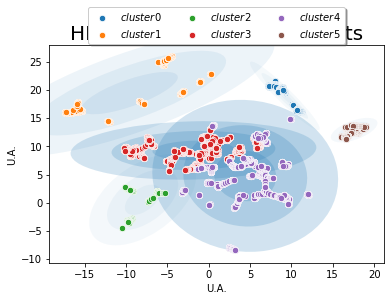

In [27]:
best_reduced_model = reduced_models[4]
utils.plot_gmm(best_reduced_model, reduced_train)
best_model_reduced.n_components
print("Coefficient of each mixture:" , best_reduced_model.weights_)
closest, _ = pairwise_distances_argmin_min(best_reduced_model.means_, reduced_train)
print('closest: ', closest)
frame_video_pairs =  [train_feats.iloc[i].name for i in closest]
print(frame_video_pairs)

## Fitting on Test Data

In [61]:
# print(cluster_predict_prob[:5])
## TODO: remove this line
test = pd.read_csv(os.path.join(os.path.curdir, 'processed_test-cleaned.csv'), index_col=None)
target_file = 'anger_13'
test = test[(test['filename'] == target_file)]
test.reset_index().set_index(['frame', 'face_id', 'filename'])
test_feats = test.filter(regex='AU.+')
cluster_predict_prob = best_model.predict_proba(test_feats)
np.set_printoptions(suppress=True, precision=4)
cluster_predict_label = np.argmax(cluster_predict_prob, axis=1)

# test_1 = cluster_predict_label[0: 18]
# test_2 = cluster_predict_label[19: 19+47]
# test_3 = cluster_predict_label[19+48: ]
print('Frame Labels For Video 1:', cluster_predict_label)
# print('Frame Labels For Video 2:', test_2)
# print('Frame Labels For Video 3:', test_3)

# If predicted probability is < 0.4, set the label to 999.
classification_thresh_prob = 0.4
for i in range(cluster_predict_prob.shape[0]):
    if cluster_predict_prob[i][cluster_predict_label[i]] < classification_thresh_prob:
        cluster_predict_label[i] = 999

Frame Labels For Video 1: [1 1 2 1 1 2 2 2 2 1 3 1 3 3 3 3 3 1 1 1 2 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 1 1 1 3 3 3 2 2 2 2 2 3 3 1 3 1 1 2 1 1 1 3 3 3 1 1 1 1 3 1 1 3
 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 2 2 3 3 3 1 2 2 2 2 1 1 1 1 1 1 3 1 1 1 1 1
 1 1 1 3 1 3 3 3 3 3 3 3 3 3 3 3 3 1 1 2 2 1 1 1 1 3 3 3 3 1 3 1 1 1 1 1 1
 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1]


In [62]:
stats.mode(cluster_predict_label)

ModeResult(mode=array([1]), count=array([73]))

### Average of AUs for ``anger_13`` video

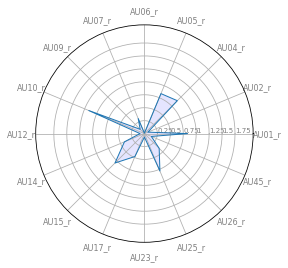

In [64]:
values = np.mean(test_feats, axis=0).tolist()
# print(values)
values += values[:1]
# print('%%%%%%%%%%%%%%           ', values, len(values))

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
axs[0] = plt.subplot(111, polar=True)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)

# Draw ylabels
axs[0].set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75, 1.0, 1.25, 1.5, 1.75], ["0.25","0.5","0.75", "1", "1.25", "1.5", '1.75'], color="grey", size=7)
plt.ylim(0,2.1)

# Plot data
axs[0].plot(angles, values, linewidth=1, linestyle='solid')

# axs[i].set_title('Cluster ' + str(i))
# Fill area
axs[0].fill(angles, values, 'b', alpha=0.1)

In [56]:
# df = pd.read_csv(os.path.join(os.path.curdir, 'processed_test.csv'))
# df.drop(df[(df['filename'] == target_file) & (df['face_id'] == 1)].index, inplace=True)
# df.to_csv(os.path.join(os.path.curdir, 'processed_test-cleaned.csv'), index=None)

In [55]:
len(df[(df['filename'] == target_file) & (df['face_id'] == 0)])

165

# 3D t-SNE visualization of clusters

In [69]:
import plotly.express as px
# fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
#               color=best_model., size='petal_length', size_max=18,
#              opacity=0.7)

# # tight layout
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))